# Advektionsgleichung (1D)

Bisher haben wir die Energieerhaltungsgleichung nur ohne den Transport von Materialien (der Advektion)
betrachtet. Häufig haben wir aber ein Problem in dem sich das Material bewegt und bestimmte Größen, wie
z.B. die Temperatur, Dichte, etc., transportiert werden müssen (z.B. in Mantleplumes). Generell gesehen, ist die
Mantelkonvektion ein Beispiel eines Systems, in welchem die Temperatur sowohl durch **Diffusion** (vor allem in
den Grenzschichten) als auch **Advektion** (vor allem in Inneren) transportiert wird.

Betrachten wir im Folgenden nur die **Advektion** alleine (d.h. k, κ = 0).

Im 1-D Fall reduziert sich die Gleichung dadurch zur reinen Advektionsgleichung:

$$
\frac{\partial{T}}{\partial{t}}=-v_x\frac{\partial{T}}{\partial{x}}. \tag{1}
$$

Diese Gleichung lässt sich durch verschiedene Diskretisierungsverfahren numerisch lösen und wir wollen
verschiedene Verfahren programieren und auf ein bestimmtes Advektionsproblem anwenden.

Betrachten wir dazu zwei 1-D Probleme (z.B. ein horizontales Temperaturprofil) mit bestimmten Anomalien:

&emsp;    • Einen Gaußchen Temperaturverlauf (ein glatter Übergang):<br>
<img src="../Figures/Exercise06_gaussian.png" alt="drawing" width="400"/> <br>


&emsp;    • Eine block-förmige Temperaturanomalie (ein sehr scharfer Übergang):<br>
<img src="../Figures/Exercise06_block.png" alt="drawing" width="400"/> <br>


Laden wir erst einmal die notwendigen Module: 

In [152]:
using Plots, Interpolations # , Dierckx
using GeoModBox.AdvectionEquation.OneD

Definieren wir nun unsere Geometrie und die benötigten numerischen Parameter (d.h.
Gitterauflösung, Gitter, etc.):

In [153]:
# Geometrische Konstanten ----------------------------------------------- #
xmin    =   0                           #   [ m ]
xmax    =   40                          #   [ m ]
# ----------------------------------------------------------------------- #
# Numerische Konstanten ------------------------------------------------- #
nc      =   100                         #   Anzahl der Gitterpunkte
Δx      =   xmax/nc                     #   Gitterlänge
ind     =   1:nc   
# ---
xc      =   xmin+Δx/2:Δx:xmax-Δx/2      #   x-Koordinate
xcwe    =   xmin-Δx/2:Δx:xmax+Δx/2      #   x-Koordinate
X       =   zeros(nc)
# ----------------------------------------------------------------------- #
# Maximale Laufzeit des Models ------------------------------------------ #
tmax    =   40.0                        #   [ s ]
# ----------------------------------------------------------------------- #
# Horizontale Geschwindigkeit ------------------------------------------- #
vx      =   1.0                         #   [ m/s ]
# ----------------------------------------------------------------------- #
# Definition der Zeitschrittlänge --------------------------------------- #
Δtfac   =   0.8                         #   Courant-Kriterium
Δt      =   Δtfac*Δx/abs(vx)
nt      =   ceil(Int,tmax/Δt)           #   Anzahl der Zeitschritte
# ----------------------------------------------------------------------- #

125

Nun können wir zum einen die FD-Methode wählen ('FTCS', 'upwind', 'downwind', 'lax', 'slf', 'semilag' - die
Gleichungen und Erläuterungen dazu sind im Detail in den Folien der Vorlesung zu finden) und zum anderen
das Anfangsprofil wählen ('block' oder 'gaussian'):

In [154]:
FD          =   (Method     = (Adv=:semilag,),)
Ini         =   (T=:gaussian,)

(T = :gaussian,)

Zur Visualisierung und zum speichern der Animationsdatei muss der Speicherort festgelegt werden:

In [155]:
# Animationssettings ---------------------------------------------------- #
path        =   string("./Results/")
anim        =   Plots.Animation(path, String[] )
filename    =   string("06_1D_advection_",Ini.T,"_",FD.Method.Adv)
save_fig    =   0
# ----------------------------------------------------------------------- #

0

Falls wir die Tracer Methode verwenden wollen, müssen wir noch die Anzahl der Tracer pro Gitterlänge
festlegen:

In [156]:
# Tracer advection method ----------------------------------------------- #
nmx         =   3       #   Number of tracers per "cell"
# ----------------------------------------------------------------------- #

3

Wollen wir nun die Anfangsbedingung (d.h. das Anfangstemperaturprofil) definieren und plotten:

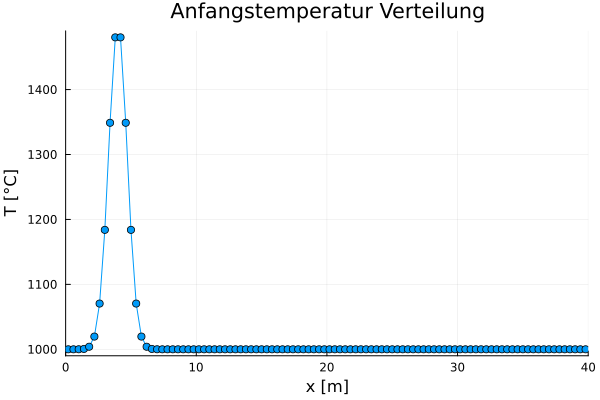

In [157]:
if Ini.T==:block 
    # Hintergrundtemperatur ----------------------------------------- #
    Tb      =   1000                #   [ K ]
    
    # Lokalität und Intensität der Temperaturanomalie --------------- #
    xTl     =   (xmax-xmin)/10
    xTr     =   xTl + (xmax-xmin)/10
    Ta      =   1500                #   [ K ]
    
    # Erstellung des Anfangstemperaturprofiles ---------------------- #
    T       =   Tb.*ones(nc)        
    T[xc.>=xTl .&& xc .<= xTr ]       .=  Ta
    Tmin    =   minimum(T)
    Tmax    =   maximum(T)
    tc      =   100
elseif Ini.T==:gaussian
    # Gaußsche Temperature Verteilung ------------------------------- #
    Tb      =   1000                #   Hintergrundtempertur
    Ampl    =   500                 #   Amplitude
    sigma   =   1                   #   Standard Abweichung
    xcG     =   (xmax-xmin)/10      #   x-Koordinate des Maximums
    T       =   zeros(nc)
    @. T    =  Tb + Ampl*exp(-((xc - xcG)^2)/sigma^2)
    
    Tmin    =   minimum(T)
    Tmax    =   maximum(T)
    tc      =   Ampl
end
TWE             =   zeros(nc+2)
TWE[2:end-1]    .=  T
TWE[1]          =   T[end]
TWE[end]        =   T[1]
TWE2            =   zeros(nc+2)

q = plot(xc, T, xlabel="x [m]", ylabel="T [°C]", 
        title="Anfangstemperatur Verteilung", 
        markershape=:circle,label="",
        xlim=(xmin,xmax), ylim=(Tmin-10, Tmax+10))
if save_fig==0
    display(q)
end

if FD.Method.Adv==:tracers
    # Gesamtanzahl der Tracer
    nm          =   (nc)*nmx
    # Abstand der Tracer    
    Δmx         =   (abs(xmin)+abs(xmax))/(nm+1)
    # x-Koordinaten der Tracer    
    xm          =   collect(xmin+Δmx:Δmx:xmax-Δmx) .+ rand(nm).*0.5*Δmx    
    # Temperatur auf den Tracern
    Tm          =   zeros(nm)    
end

Nun können wir die Gleichungen zur Lösung der Advektionsgleichung programieren. 

In [158]:
# Lösen der Advektionsgleichung --------------------------------------- #
for i = 2:nt
    display(string("Time step: ",i))
    TWE[2:end-1]    .=  T
    TWE[1]          =   T[end]
    TWE[end]        =   T[1]
    
    if FD.Method.Adv==:FTCS        
        T       .= 
            TWE[2:end-1] .- (vx*Δt/2.0/Δx).*(TWE[3:end].- TWE[1:end-2])
    elseif FD.Method.Adv==:upwind
        if vx > 0
            T       .= 
                TWE[2:end-1] .- vx*Δt/Δx.*( TWE[2:end-1] .- TWE[1:end-2] )
        elseif vx < 0
            T .= 
                TWE[2:end-1] .- vx*Δt/Δx.*( TWE[3:end] .- TWE[2:end-1] ) 
        end
    elseif FD.Method.Adv==:downwind
        T   .= 
            TWE[2:end-1] .- vx*Δt/Δx.*( TWE[3:end] .- TWE[2:end-1] )
    elseif FD.Method.Adv==:lax
        T   .= ( TWE[3:end] .+ TWE[1:end-2])./2 .-
            (vx*Δt/2/Δx) .* (TWE[3:end] .- TWE[1:end-2])
    elseif FD.Method.Adv==:slf
        if i==2
            T   .= 
                TWE[2:end-1] .- vx*Δt/Δx*( TWE[3:end] .- TWE[1:end-2])
        else
            T   .= 
                TWE2[2:end-1] .- vx*Δt/Δx .* (TWE[3:end] .- TWE[1:end-2])
        end
        TWE2 .= TWE
    elseif FD.Method.Adv==:semilag
        X           .=  xc .- Δt*vx
        itp_cubic   =   cubic_spline_interpolation(xcwe,TWE)
        T           .=   itp_cubic.(X)
        # spl     =   Spline1D(xcwe,TWE;k=3)
        # T       =   spl.(X)
        # Itp1D_Centers2Markers!(T,X,TWE,xcwe,Δx,xmin-Δx)        
    elseif FD.Method.Adv==:tracers 
        itp_cubic   =   cubic_spline_interpolation(xcwe,TWE)
        Tm          .=  itp_cubic.(xm)
        s = plot(xm,Tm)        
        # spl     =   Spline1D(xcwe,TWE;k=1) 
        # Tm      =   spl.(xm)        
        #Itp1D_Centers2Markers!(Tm,xm,TWE,xcwe,Δx,xmin-Δx)
        RK4O1D!( xm, Δt, vx, xmin, xmax )        
        XMT         =   hcat(xm,Tm)        
        XMT         =   sortslices(XMT,dims=1)
        xm          .=  XMT[:,1]
        Tm          .=  XMT[:,2]
        plot!(s,xm,Tm)
        display(s)
        @show xm Tm
        @show typeof(xm) size(xm) typeof(Tm) size(Tm)
        itp_cubic2  =   cubic_spline_interpolation(xm,Tm) 
        # Does not work so far, since interpolations.jl does only allow regular spacing for
        # coordinates! 
        T           .=  itp_cubic2.(xc)
        #spl2    =   Spline1D(xm,Tm;k=1)
        #T       =   spl2.(xc)
        #Itp1D_Markers2Centers!( T, xc, Tm, xm, Δx, xmin)
    end
    
    display(string("ΔT=",((Tmax-maximum(T))/Tmax)*100))

    # Darstellung des Profils
    q = plot(xc, T, xlabel="x [m]", ylabel="T [°C]", 
            title="Anfangstemperatur Verteilung", 
            markershape=:circle,label="",
            xlim=(xmin,xmax), ylim=(Tmin-10, Tmax+10))
    #plot!(q,xc, T2,linstyle=:dash)
    if FD.Method.Adv==:tracers 
        plot!(xm,Tm,markershape=:circle,label="",linealpha=:0)        
    end    
    if save_fig == 1
        Plots.frame(anim)
    else
        #display(q)
    end
end

# Speicher Animation ---------------------------------------------------- #
if save_fig == 1
    # Write the frames to a GIF file
    Plots.gif(anim, string( path, filename, ".gif" ), fps = 15)
    foreach(rm, filter(startswith(string(path,"00")), readdir(path,join=true)))
end
# ----------------------------------------------------------------------- #


"Time step: 2"

"ΔT=-0.8220493335298236"

"Time step: 3"

"ΔT=-1.2358993920288668"

"Time step: 4"

"ΔT=-1.2287656673330072"

"Time step: 5"

"ΔT=-0.8029262446779685"

"Time step: 6"

"ΔT=0.024609649386493376"

"Time step: 7"

"ΔT=-0.727388467008823"

"Time step: 8"

"ΔT=-1.1510170044076684"

"Time step: 9"

"ΔT=-1.1590067537246256"

"Time step: 10"

"ΔT=-0.7523276534629675"

"Time step: 11"

"ΔT=0.0535832050759885"

"Time step: 12"

"ΔT=-0.6367030154680443"

"Time step: 13"

"ΔT=-1.068376591595362"

"Time step: 14"

"ΔT=-1.0896307718521134"

"Time step: 15"

"ΔT=-0.7003333185863682"

"Time step: 16"

"ΔT=0.08546928746327687"

"Time step: 17"

"ΔT=-0.549692560990301"

"Time step: 18"

"ΔT=-0.9881208985945013"

"Time step: 19"

"ΔT=-1.0211525881155405"

"Time step: 20"

"ΔT=-0.6477230082737543"

"Time step: 21"

"ΔT=0.11934972458525347"

"Time step: 22"

"ΔT=-0.4660070283791182"

"Time step: 23"

"ΔT=-0.9101949944842983"

"Time step: 24"

"ΔT=-0.9537953610814535"

"Time step: 25"

"ΔT=-0.5949470843148613"

"Time step: 26"

"ΔT=0.15462194562428405"

"Time step: 27"

"ΔT=-0.38533178946819535"

"Time step: 28"

"ΔT=-0.8344874481105519"

"Time step: 29"

"ΔT=-0.8876538853482906"

"Time step: 30"

"ΔT=-0.5422830396728547"

"Time step: 31"

"ΔT=0.19087083488219858"

"Time step: 32"

"ΔT=-0.30739505609777745"

"Time step: 33"

"ΔT=-0.7608728289248712"

"Time step: 34"

"ΔT=-0.8227593780769522"

"Time step: 35"

"ΔT=-0.4899087747320438"

"Time step: 36"

"ΔT=0.22779960725899678"

"Time step: 37"

"ΔT=-0.231963147959613"

"Time step: 38"

"ΔT=-0.6892267934362264"

"Time step: 39"

"ΔT=-0.759109442883666"

"Time step: 40"

"ΔT=-0.4379409162901411"

"Time step: 41"

"ΔT=0.26519004074796937"

"Time step: 42"

"ΔT=-0.15883429904005866"

"Time step: 43"

"ΔT=-0.6194316477981919"

"Time step: 44"

"ΔT=-0.6966833691753382"

"Time step: 45"

"ΔT=-0.38645657085430396"

"Time step: 46"

"ΔT=0.3028781780187808"

"Time step: 47"

"ΔT=-0.08783312541442351"

"Time step: 48"

"ΔT=-0.5513781715089117"

"Time step: 49"

"ΔT=-0.6354504768666236"

"Time step: 50"

"ΔT=-0.3355064453934658"

"Time step: 51"

"ΔT=0.3407387403106387"

"Time step: 52"

"ΔT=-0.018806077876272007"

"Time step: 53"

"ΔT=-0.48496588584743167"

"Time step: 54"

"ΔT=-0.5753748788826422"

"Time step: 55"

"ΔT=-0.2851231376219622"

"Time step: 56"

"ΔT=0.37867472946444936"

"Time step: 57"

"ΔT=0.04838221204200813"

"Time step: 58"

"ΔT=-0.42010267336386264"

"Time step: 59"

"ΔT=-0.5164182830034972"

"Time step: 60"

"ΔT=-0.23532656972988622"

"Time step: 61"

"ΔT=0.4166102642315288"

"Time step: 62"

"ΔT=0.11385185857869788"

"Time step: 63"

"ΔT=-0.35670414723702865"

"Time step: 64"

"ΔT=-0.4585416700753808"

"Time step: 65"

"ΔT=-0.186127656619196"

"Time step: 66"

"ΔT=0.4544855107615424"

"Time step: 67"

"ΔT=0.17771007520589907"

"Time step: 68"

"ΔT=-0.29469295113033495"

"Time step: 69"

"ΔT=-0.4017063051575399"

"Time step: 70"

"ΔT=-0.13753084291223308"

"Time step: 71"

"ΔT=0.49225301290389867"

"Time step: 72"

"ΔT=0.2400530805059023"

"Time step: 73"

"ΔT=-0.2339980710695177"

"Time step: 74"

"ΔT=-0.34587434183411325"

"Time step: 75"

"ΔT=-0.08953589307432565"

"Time step: 76"

"ΔT=0.5298749838359861"

"Time step: 77"

"ΔT=0.30096765397300107"

"Time step: 78"

"ΔT=-0.1745541942104981"

"Time step: 79"

"ΔT=-0.2910091733803259"

"Time step: 80"

"ΔT=-0.04213917578002953"

"Time step: 81"

"ΔT=0.5673212734171114"

"Time step: 82"

"ΔT=0.3605324164712995"

"Time step: 83"

"ΔT=-0.11630112701164771"

"Time step: 84"

"ΔT=-0.2370756242189787"

"Time step: 85"

"ΔT=0.004665401664249847"

"Time step: 86"

"ΔT=0.6045678202094346"

"Time step: 87"

"ΔT=0.41881889251332305"

"Time step: 88"

"ΔT=-0.0591832746635113"

"Time step: 89"

"ΔT=-0.18404003983521683"

"Time step: 90"

"ΔT=0.05088570556828111"

"Time step: 91"

"ΔT=0.6415954573421991"

"Time step: 92"

"ΔT=0.47589239825570046"

"Time step: 93"

"ΔT=-0.0031491787297612114"

"Time step: 94"

"ΔT=-0.1318703120614198"

"Time step: 95"

"ΔT=0.0965308648052963"

"Time step: 96"

"ΔT=0.6783889807846131"

"Time step: 97"

"ΔT=0.5318127891374703"

"Time step: 98"

"ΔT=0.05184889208104679"

"Time step: 99"

"ΔT=-0.08053586346719993"

"Time step: 100"

"ΔT=0.14161088797539054"

"Time step: 101"

"ΔT=0.7149364131749948"

"Time step: 102"

"ΔT=0.5866350924599386"

"Time step: 103"

"ΔT=0.10585528827757533"

"Time step: 104"

"ΔT=-0.03000757813072118"

"Time step: 105"

"ΔT=0.18613689571692554"

"Time step: 106"

"ΔT=0.751226912618655"

"Time step: 107"

"ΔT=0.6404127032303124"

"Time step: 108"

"ΔT=0.15890838945730634"

"Time step: 109"

"ΔT=0.019465166128989405"

"Time step: 110"

"ΔT=0.23264623249755045"

"Time step: 111"

"ΔT=0.7767805354146782"

"Time step: 112"

"ΔT=0.687613323256029"

"Time step: 113"

"ΔT=0.19072680905739858"

"Time step: 114"

"ΔT=0.5326261777185785"

"Time step: 115"

"ΔT=0.6888696032967606"

"Time step: 116"

"ΔT=1.2241988037566713"

"Time step: 117"

"ΔT=1.1246828559114745"

"Time step: 118"

"ΔT=0.666051530670396"

"Time step: 119"

"ΔT=0.5318330763900188"

"Time step: 120"

"ΔT=0.7299153642027834"

"Time step: 121"

"ΔT=1.257774724929349"

"Time step: 122"

"ΔT=1.1730868276580628"

"Time step: 123"

"ΔT=0.7129975763989824"

"Time step: 124"

"ΔT=0.5761455119030351"

"Time step: 125"

"ΔT=0.7693879152382588"